<a href="https://colab.research.google.com/github/LANZhengyang/MFML_Bayesian_KNN/blob/master/MFML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from functools import reduce
import time

iris = datasets.load_iris()
X = iris.data
y = iris.target

## Original KNN

time cost 386.04793787002563 s


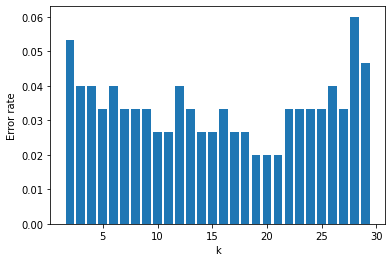

In [21]:


time_start=time.time()
all_error = []
# test k from 2 to 30
for k in range(2,30):
  sum=0
  for i in range(len(y)):
    # Do the cross validation
    Train_x=np.delete(X, i, axis=0)
    Train_y=np.delete(y, i, axis=0)
    neigh = neighbors.KNeighborsClassifier(n_neighbors=k)
    neigh.fit(Train_x, Train_y)
    for j in range(y.shape[0]-1):
      if neigh.predict(X[i][np.newaxis, :]) != y[i]:
        sum=sum+ 1/ (y.shape[0]-1)
  sum = sum/ (len(y))
  all_error.append(sum)

plt.bar(range(2,30),all_error)
plt.xlabel("k")
plt.ylabel("Error rate")

time_end=time.time()
print('time cost',time_end-time_start,'s')

In [0]:
class knn():
    def fit(self,X,y,n):
        self.X = X
        self.y=y
        self.n=n
    #dustance between x1 and x2
    def distance(self,x_1,x_2):        
        return np.linalg.norm(x_1-x_2,ord=self.X.shape[1])   

    def get_neighbours(self,x):        
        all_distance = []
        for i in range(self.y.shape[0]):
            all_distance.append(self.distance(x,self.X[i]))       
        return np.argsort(all_distance)[:self.n]

    def potential_function(self,x,y_i):
      neighbors=self.get_neighbours(x)

      return np.sum(y[neighbors] == y_i)

    def mutual_neighbours(self,index,y_i):

      classifier = knn()
      Train_x=np.delete(self.X, index, axis=0)
      Train_y=np.delete(self.y, index, axis=0)
      classifier.fit(Train_x,Train_y,self.n)
      neighbors_index = classifier.get_neighbours(self.X[index])
      number_mutual_neighbours=0
      for i in range(self.n):
        Train_x_temp = self.X
        Train_y_temp = self.y
        Train_x_temp=np.delete(Train_x_temp, neighbors_index[i], axis=0)
        Train_y_temp=np.delete(Train_y_temp, neighbors_index[i], axis=0)
        classifier_temp = knn()
        classifier_temp.fit(Train_x_temp,Train_y_temp,self.n)
        if self.X[index] in Train_x_temp[classifier_temp.get_neighbours(self.X[neighbors_index[i]])]:
          if y_i == y[neighbors_index[i]] :       
            number_mutual_neighbours+=1
      return number_mutual_neighbours

#formula 1, when get = conditional
def distribution(index,beta,X,y,k,get="joint",y_i=0):
  classifier = knn()
  Train_x=np.delete(X, index, axis=0)
  Train_y=np.delete(y, index, axis=0)
  classifier.fit(Train_x,Train_y,k)
  all_dis=[]
  for j in range(3):
    pr_y_i_up = np.exp(beta*classifier.potential_function(X[index],j)/k)
    pr_y_i_down=0
    for i in range(3):
      pr_y_i_down = pr_y_i_down + (np.exp(beta*classifier.potential_function(X[index],i)/k))
    all_dis.append(pr_y_i_up/pr_y_i_down)
  z = np.sum(all_dis)
  if get=="joint":
    return all_dis/z
  elif get =="conditional":
    return all_dis[y_i]/z

#formula 2
def combined_predictors(X_given,beta,k,X,y,y_given):
  predict_list=[]
  Train_x=np.delete(X, X_given, axis=0)
  Train_y=np.delete(y, X_given, axis=0)
  predict_list=[]
  for i in range(len(X_given)):
    predict_list.append(distribution(index=X_given[i],beta=beta,X=X,y=y,k=k,get="conditional",y_i=y_given[i]))
  return reduce(lambda x,y:x * y,predict_list)

#formula 4
def distribution_Boltzmann(index,beta,X,y,k,get="conditional",y_i=0):

  classifier = knn()
  classifier.fit(X,y,k)
  classifier_temp = knn()
  Train_x=np.delete(X, index, axis=0)
  Train_y=np.delete(y, index, axis=0)
  classifier_temp.fit(Train_x,Train_y,k)
  all_dis=[]
  neighbors_index = classifier_temp.get_neighbours(X[index])
  for j in range(3):
    pr_y_i_left = classifier_temp.potential_function(X[index],j)
    pr_y_i_right= classifier.mutual_neighbours(index,y_i=y[index])
  #  print(pr_y_i_right)
    all_dis.append(np.exp((beta/k)*(pr_y_i_left+pr_y_i_right)))
  z = np.sum(all_dis) 
 # print(z)
  if get=="joint":

    return all_dis/z
  elif get =="conditional":
    return all_dis[y_i]/z

# formula 8
def pseudo_likelihood_approximation(beta,X,y,k):
    classifier = knn()
    classifier.fit(X,y,k) 
    prob=1
    for i in range(len(y)):

        Train_x_temp = X
        Train_y_temp = y
        Train_x_temp=np.delete(X, i, axis=0)
        Train_y_temp=np.delete(y, i, axis=0)
        classifier_temp = knn()
        classifier_temp.fit(Train_x_temp,Train_y_temp,k) 
        neighbors_index = classifier_temp.get_neighbours(X[i])
        up_left_sum = classifier_temp.potential_function(X[i], y[i])
        up_right_sum = classifier.mutual_neighbours(i,y[i])

        up_sum = np.exp((beta/k)*(up_left_sum+up_right_sum))
             
        down_sum = 0
        for g in range(2):
          down_left_sum = classifier_temp.potential_function(X[i],g)
          down_right_sum = classifier.mutual_neighbours(i,y_i=g)
          print(np.exp((beta/k)*(down_left_sum + down_right_sum)))
          down_sum += np.exp((beta/k)*(down_left_sum + down_right_sum))
        print("-------")
        # print("up",up_sum)
        # print("down",down_sum)
        # print("down",down__sum)
        # print("all",(up_sum/down_sum))
        prob = prob*(up_sum/down_sum)
      
    return prob



def Z(beta,k,X,y):
  s=0
  for i in range(len(y)):
    Train_x_temp = X
    Train_y_temp = y
    Train_x_temp=np.delete(X, i, axis=0)
    Train_y_temp=np.delete(y, i, axis=0)
    classifier_temp = knn()
    classifier_temp.fit(Train_x_temp,Train_y_temp,k)    
    s+= classifier_temp.potential_function(X[i],y[i]) /k


def get_S(X=X,y=y,k=40):
    s = 0
    for j in range(len(y)):
        Train_x = np.delete(X, j, axis=0)
        Train_y = np.delete(y, j, axis=0)
        classifier_neighbours = knn()
        classifier_neighbours.fit(Train_x,Train_y,k)
        for i in range(k):
            s += classifier_neighbours.potential_function(X[j], y[j])
    return s/k

In [12]:
get_S(X=X[:90],y=y[:90],k=30)

2697.0

In [0]:
para_all=np.zeros([len(range(1,12)),len(range(2,25))])

In [0]:
para=[0,0]
proba_max=0
for beta in range(1,12):
  for k in range(2,25):
    proba=1    
    for n in range(len(y)):
      proba=proba*distribution(index=n,beta=beta,X=X,y=y,k=k,get="conditional",y_i=y[n])
    print("proba(likelihood)=",proba,"beta=",beta,"k=",k)
    para_all[beta-1][k-10]=proba
    if proba>proba_max:
      # print("max_likelihood=",proba)
      # print("with beta=",beta,"k=",k)
      proba_max = proba 
      para[0]=beta
      para[1]=k
print("max_likelihood=",proba_max)
print("with beta=",para[0],"k=",para[1])

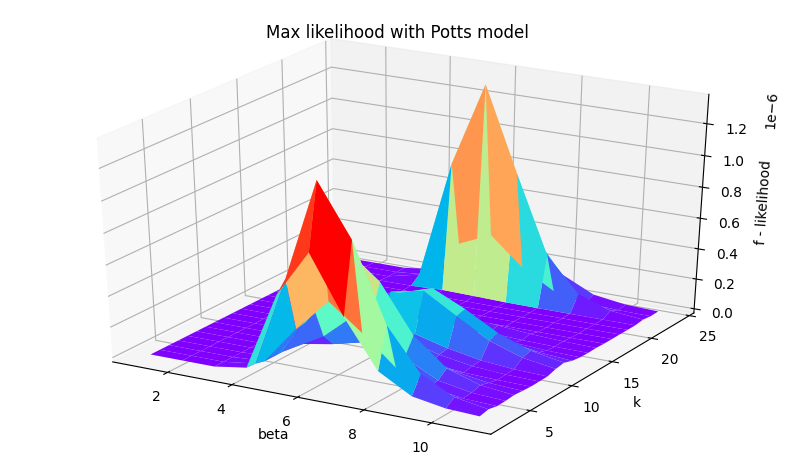

In [39]:
fig = plt.figure(figsize=(10,6),dpi=100)  
ax3 = plt.axes(projection='3d')
#data
beta = np.arange(1,12)
k = np.arange(2,25)
beta, k = np.meshgrid(beta, k)

Z = para_all[beta-1,k-2]


#plot
ax3.plot_surface(beta,k,Z,rstride = 1, cstride = 1,cmap='rainbow')
ax3.set_xlabel('beta')
ax3.set_ylabel('k')
ax3.set_zlabel('f - likelihood')
ax3.set_title("Max likelihood with Potts model")
plt.show()

In [42]:
para=[0,0]
proba_max=0
for beta in range(2,10):
  for k in range(19,20):
    proba=1    
    for n in range(len(y)):
      proba=proba*distribution_Boltzmann(index=n,beta=beta,X=X,y=y,k=k,get="conditional",y_i=y[n])
    print("proba(likelihood)=",proba,"beta=",beta,"k=",k)
    if proba>proba_max:
      proba_max = proba 
      para[0]=beta
      para[1]=k
print("max_likelihood=",proba)
print("with beta=",para[0],"k=",para[1])

proba(likelihood)= 1.9292878485556593e-22 beta= 2 k= 19
proba(likelihood)= 2.4695110137266205e-13 beta= 3 k= 19
proba(likelihood)= 2.4218175128069643e-09 beta= 4 k= 19
proba(likelihood)= 9.683931094042154e-08 beta= 5 k= 19
proba(likelihood)= 3.329670349335595e-07 beta= 6 k= 19
proba(likelihood)= 3.7646655405684843e-07 beta= 7 k= 19
proba(likelihood)= 2.499842013264491e-07 beta= 8 k= 19
proba(likelihood)= 1.2601141149120943e-07 beta= 9 k= 19
max_likelihood= 1.2601141149120943e-07
with beta= 7 k= 19


In [0]:
pseudo_likelihood_approximation(beta=10,X=X[:100],y=y[:100],k=10)

In [0]:
para=[0,0]
proba_max=0
for beta in range(4,10):
  for k in range(19,20):   
    proba = pseudo_likelihood_approximation(beta=beta,X=X[:100],y=y[:100],k=k)
    print("proba(likelihood)=",proba,"beta=",beta,"k=",k)
    if proba>proba_max:
      proba_max = proba 
      para[0]=beta
      para[1]=k
print("max_likelihood=",proba)
print("with beta=",para[0],"k=",para[1])